# Borrador de propuestas para proyecto 2 (JALR)

In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

In [3]:
from src.utils.utils import load_df, save_df
from src.pipelines.feature_engineering import feature_generation, feature_selection

## Verificación de etapas pasadas

### Ingestión

In [4]:
ingestion_path = '../../output/ingest_df.pkl'
df_ingest = load_df(ingestion_path)
df_ingest.head()

,folio,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,VENUSTIANO CARRANZA,accidente-choque sin lesionados,BOTÓN DE AUXILIO,1,0
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,CUAJIMALPA,accidente-choque con lesionados,BOTÓN DE AUXILIO,1,0
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,TLALPAN,accidente-choque sin lesionados,LLAMADA DEL 066,1,1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,MAGDALENA CONTRERAS,accidente-choque sin lesionados,LLAMADA DEL 066,1,1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,MIGUEL HIDALGO,accidente-choque sin lesionados,LLAMADA DEL 066,1,0


In [5]:
df_ingest.shape

(1383138, 9)

In [6]:
df_ingest.label.value_counts()

0    1100835
1     282303
Name: label, dtype: int64

Tenemos labels en todas las observaciones existentes.

### Transformación de train

In [7]:
train_transformation_path = '../../output/transformation_df.pkl'
df_train_trans = load_df(train_transformation_path)
df_train_trans.head()

,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label,sin_hr,cos_hr,sin_mes,cos_mes
1109067,2013-12-31,21:16:55,martes,cuauhtemoc,accidente-choque con lesionados,radio,1,0,-0.707107,0.707107,0.5,0.866025
372668,2013-12-31,23:45:27,martes,tlahuac,accidente-choque con lesionados,radio,1,0,-0.258819,0.965926,0.5,0.866025
1164288,2013-12-31,23:33:54,martes,cuauhtemoc,accidente-choque sin lesionados,llamada del 066,1,0,-0.258819,0.965926,0.5,0.866025
1109077,2013-12-31,23:53:50,martes,magdalena contreras,accidente-choque sin lesionados,llamada del 066,1,0,-0.258819,0.965926,0.5,0.866025
372686,2013-12-31,21:58:26,martes,iztapalapa,accidente-choque sin lesionados,llamada del 066,1,0,-0.707107,0.707107,0.5,0.866025


In [8]:
df_train_trans.shape

(968197, 12)

In [9]:
df_train_trans.label.value_counts()

0    766837
1    201360
Name: label, dtype: int64

Tenemos los labels en todas las observaciones requeridas para training.

### Transformación de test

Esto es antes de feature engineering.

In [10]:
test_path = '../../output/test_df.pkl'
df_test = load_df(test_path)
df_test.head()

,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label,sin_hr,cos_hr,sin_mes,cos_mes
1251176,2018-10-19,20:57:10,viernes,alvaro obregon,accidente-choque sin lesionados,llamada del 911,10,0,-0.866025,0.500000,-0.866025,0.5
1251177,2018-10-19,14:52:28,viernes,benito juarez,accidente-choque sin lesionados,llamada del 911,10,0,-0.500000,-0.866025,-0.866025,0.5
1251163,2018-10-19,15:28:27,viernes,cuauhtemoc,accidente-choque sin lesionados,llamada del 911,10,0,-0.707107,-0.707107,-0.866025,0.5
1251178,2018-10-19,20:21:12,viernes,iztapalapa,accidente-choque con lesionados,llamada del 911,10,0,-0.866025,0.500000,-0.866025,0.5
1251146,2018-10-19,23:36:55,viernes,coyoacan,accidente-choque con lesionados,llamada del 911,10,0,-0.258819,0.965926,-0.866025,0.5


In [11]:
df_test.shape

(414941, 12)

In [12]:
df_test.label.value_counts()

0    333998
1     80943
Name: label, dtype: int64

Tenemos label en todas las observaciones necesarias.

### Train feature engineering

In [13]:
train_fe_path = '../../output/fe_df.pkl'
df_train = load_df(train_fe_path)
df_train = df_train.astype({'label':'category'})
df_train.head()

,alvaro_obregon,azcapotzalco,benito_juarez,coyoacan,cuajimalpa,cuauhtemoc,gustavo_a_madero,iztacalco,iztapalapa,magdalena_contreras,...,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion,tipo_dia,trimestre,sin_trim,cos_trim,llamada
0,0,0,0,0,0,1,0,0,0,0,...,-0.707107,0.707107,0.5,0.866025,2013-12-31 21:16:55,0,1,1,6.12323e-17,0
1,0,0,0,0,0,0,0,0,0,0,...,-0.258819,0.965926,0.5,0.866025,2013-12-31 23:45:27,0,1,1,6.12323e-17,0
2,0,0,0,0,0,1,0,0,0,0,...,-0.258819,0.965926,0.5,0.866025,2013-12-31 23:33:54,0,1,1,6.12323e-17,1
3,0,0,0,0,0,0,0,0,0,1,...,-0.258819,0.965926,0.5,0.866025,2013-12-31 23:53:50,0,1,1,6.12323e-17,1
4,0,0,0,0,0,0,0,0,1,0,...,-0.707107,0.707107,0.5,0.866025,2013-12-31 21:58:26,0,1,1,6.12323e-17,1


In [14]:
df_train.shape

(968197, 37)

In [15]:
df_train.label.value_counts()

0    766837
1    201360
Name: label, dtype: int64

In [16]:
201360 / (766837 + 201360)

0.20797420359699523

### Test feature engineering

In [17]:
test_fe_path = '../../output/test_fe_df.pkl'
df_test = load_df(test_fe_path)
df_test = df_test.astype({'label':'category'})
df_test.head()

,alvaro_obregon,azcapotzalco,benito_juarez,coyoacan,cuajimalpa,cuauhtemoc,gustavo_a_madero,iztacalco,iztapalapa,magdalena_contreras,...,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion,tipo_dia,trimestre,sin_trim,cos_trim,llamada
0,1,0,0,0,0,0,0,0,0,0,...,-0.866025,0.5,-0.866025,0.5,2018-10-19 20:57:10,1,4,-2.44929e-16,1,1
1,0,0,1,0,0,0,0,0,0,0,...,-0.5,-0.866025,-0.866025,0.5,2018-10-19 14:52:28,1,4,-2.44929e-16,1,1
2,0,0,0,0,0,1,0,0,0,0,...,-0.707107,-0.707107,-0.866025,0.5,2018-10-19 15:28:27,1,4,-2.44929e-16,1,1
3,0,0,0,0,0,0,0,0,1,0,...,-0.866025,0.5,-0.866025,0.5,2018-10-19 20:21:12,1,4,-2.44929e-16,1,1
4,0,0,0,1,0,0,0,0,0,0,...,-0.258819,0.965926,-0.866025,0.5,2018-10-19 23:36:55,1,4,-2.44929e-16,1,1


In [18]:
df_test.shape

(414941, 37)

In [19]:
df_test.label.value_counts()

0    333998
1     80943
Name: label, dtype: int64

## Modelado

Genera un maginc loop con los siguientes dos algoritmos cada uno modificando al menos 2 hiperparámetros con al menos 3 configuraciones diferentes y utilizando un CV de 5 a través de un `GridSearchCV`. El criterio de selección del mejor modelo será la eficiencia del modelo:

* `DecisionTree`
* `RandomForest`

In [20]:
df_train = df_train.sort_values('timestamp_creacion', ascending=True, ignore_index=True)
df_train.head()

,alvaro_obregon,azcapotzalco,benito_juarez,coyoacan,cuajimalpa,cuauhtemoc,gustavo_a_madero,iztacalco,iztapalapa,magdalena_contreras,...,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion,tipo_dia,trimestre,sin_trim,cos_trim,llamada
0,0,0,0,0,0,0,1,0,0,0,...,-0.258819,-0.965926,0.5,0.866025,2013-12-31 13:01:33,0,1,1,6.12323e-17,1
1,0,0,1,0,0,0,0,0,0,0,...,-0.258819,-0.965926,0.5,0.866025,2013-12-31 13:53:09,0,1,1,6.12323e-17,1
2,0,0,1,0,0,0,0,0,0,0,...,-0.258819,-0.965926,0.5,0.866025,2013-12-31 13:53:24,0,1,1,6.12323e-17,1
3,1,0,0,0,0,0,0,0,0,0,...,-1,-1.83697e-16,0.5,0.866025,2013-12-31 18:21:47,0,1,1,6.12323e-17,1
4,0,1,0,0,0,0,0,0,0,0,...,-0.965926,0.258819,0.5,0.866025,2013-12-31 19:02:13,0,1,1,6.12323e-17,1


In [21]:
df_train.shape[1]

37

In [22]:
df_test = df_test.sort_values('timestamp_creacion', ascending=True, ignore_index=True)
df_test.head()

,alvaro_obregon,azcapotzalco,benito_juarez,coyoacan,cuajimalpa,cuauhtemoc,gustavo_a_madero,iztacalco,iztapalapa,magdalena_contreras,...,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion,tipo_dia,trimestre,sin_trim,cos_trim,llamada
0,0,0,0,0,0,0,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:02:01,1,4,-2.44929e-16,1,1
1,0,0,0,0,0,1,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:12:45,1,4,-2.44929e-16,1,1
2,0,0,0,1,0,0,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:18:43,1,4,-2.44929e-16,1,1
3,0,0,0,1,0,0,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:18:52,1,4,-2.44929e-16,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:29:13,1,4,-2.44929e-16,1,0


In [23]:
df_test.shape[1]

37

In [24]:
df_train.columns

Index(['alvaro_obregon', 'azcapotzalco', 'benito_juarez', 'coyoacan',
       'cuajimalpa', 'cuauhtemoc', 'gustavo_a_madero', 'iztacalco',
       'iztapalapa', 'magdalena_contreras', 'miguel_hidalgo', 'milpa_alta',
       'tlahuac', 'tlalpan', 'venustiano_carranza', 'xochimilco', 'accidente',
       'cadaver', 'detencion_ciudadana', 'lesionado', 'sismo',
       'fecha_creacion', 'hora_creacion', 'dia_semana', 'tipo_entrada', 'mes',
       'label', 'sin_hr', 'cos_hr', 'sin_mes', 'cos_mes', 'timestamp_creacion',
       'tipo_dia', 'trimestre', 'sin_trim', 'cos_trim', 'llamada'],
      dtype='object')

In [25]:
# features seleccionados en proyecto 1
features = ['accidente', 'cadaver', 'detencion_ciudadana', 'lesionado', 'sismo', 'llamada']

In [26]:
x_train = df_train[features]
x_test = df_test[features]

y_train = df_train['label']
y_test = df_test['label']

In [27]:
x_train.head()

,accidente,cadaver,detencion_ciudadana,lesionado,sismo,llamada
0,0,0,0,1,0,1
1,1,0,0,0,0,1
2,1,0,0,0,0,1
3,1,0,0,0,0,1
4,1,0,0,0,0,1


In [28]:
x_test.head()

,accidente,cadaver,detencion_ciudadana,lesionado,sismo,llamada
0,1,0,0,0,0,1
1,1,0,0,0,0,1
2,1,0,0,0,0,1
3,1,0,0,0,0,1
4,1,0,0,0,0,0


In [29]:
y_train.head()

0    0
1    0
2    0
3    1
4    0
Name: label, dtype: category
Categories (2, int64): [0, 1]

In [30]:
y_test.head()

0    0
1    0
2    0
3    0
4    1
Name: label, dtype: category
Categories (2, int64): [0, 1]

### Magic Loop

In [31]:
algorithms_dict = {
    'tree': 'tree_grid_search',
    'random_forest': 'rf_grid_search'
}

In [32]:
grid_search_dict = {
    'tree_grid_search': {
        'max_depth': [15, 20, 25],
        'min_samples_leaf': [3, 5, 7]
    }, 
    'rf_grid_search': {
        'n_estimators': [100, 300, 500],
        'max_depth': [5, 10, 15],
        'min_samples_leaf': [6, 8, 10]
    }
}

In [33]:
estimators_dict = {
    'tree': DecisionTreeClassifier(random_state=2004),
    'random_forest': RandomForestClassifier(oob_score=True, random_state=2222)
}

In [34]:
def magic_loop(algorithms, features, labels):
    best_estimators = []
    
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        
        tscv = TimeSeriesSplit(n_splits=5)
        gs = GridSearchCV(estimator, grid_params, scoring='precision', 
                          return_train_score=True, cv=tscv, n_jobs=-1)
        
        #train
        gs.fit(features, labels)
        #best estimator
        best_estimators.append(gs)
        
        
    return best_estimators

In [35]:
algorithms = ['tree', 'random_forest']

In [36]:
best = magic_loop(algorithms, x_train, y_train)

In [37]:
best_tree = best[0].best_estimator_
best_tree

DecisionTreeClassifier(max_depth=15, min_samples_leaf=3, random_state=2004)

In [38]:
best_forest = best[1].best_estimator_
best_forest

RandomForestClassifier(max_depth=5, min_samples_leaf=6, oob_score=True,
                       random_state=2222)

### Precisión

In [39]:
tree_predicted_scores = best_tree.predict_proba(x_test)
tree_predicted_scores[:10]

array([[0.75348211, 0.24651789],
       [0.75348211, 0.24651789],
       [0.75348211, 0.24651789],
       [0.75348211, 0.24651789],
       [0.94380567, 0.05619433],
       [0.75348211, 0.24651789],
       [0.75348211, 0.24651789],
       [0.75348211, 0.24651789],
       [0.85304657, 0.14695343],
       [0.85304657, 0.14695343]])

In [40]:
forest_predicted_scores = best_forest.predict_proba(x_test)
forest_predicted_scores[0:10]

array([[0.75349507, 0.24650493],
       [0.75349507, 0.24650493],
       [0.75349507, 0.24650493],
       [0.75349507, 0.24650493],
       [0.94377017, 0.05622983],
       [0.75349507, 0.24650493],
       [0.75349507, 0.24650493],
       [0.75349507, 0.24650493],
       [0.85306976, 0.14693024],
       [0.85306976, 0.14693024]])

In [41]:
tree_prob_df = pd.DataFrame(tree_predicted_scores, columns=['tree_neg', 'tree_pos'])
tree_prob_df.head()

,tree_neg,tree_pos
0,0.753482,0.246518
1,0.753482,0.246518
2,0.753482,0.246518
3,0.753482,0.246518
4,0.943806,0.056194


In [42]:
forest_prob_df = pd.DataFrame(forest_predicted_scores, columns=['forest_neg', 'forest_pos'])
forest_prob_df.head()

,forest_neg,forest_pos
0,0.753495,0.246505
1,0.753495,0.246505
2,0.753495,0.246505
3,0.753495,0.246505
4,0.943770,0.056230


In [43]:
prob_df = tree_prob_df
prob_df = prob_df.drop(columns=['tree_neg'])
prob_df['forest_pos'] = forest_prob_df.forest_pos

In [44]:
prob_df.head()

,tree_pos,forest_pos
0,0.246518,0.246505
1,0.246518,0.246505
2,0.246518,0.246505
3,0.246518,0.246505
4,0.056194,0.056230


Evaluando la precisión de ambos modelos a diferentes puntos de corte.

In [45]:
def evaluate_precision(y_label, y_prob, cut):
    y_pred = [value >= cut for value in y_prob]
    precision = precision_score(y_label, y_pred)
    
    return precision


def max_precision(y_label, y_prob):
    max_precision = -1
    max_precision_cut = -1
    
    for i in range(1, 101):
        cut = i / 100
        precision = evaluate_precision(y_label, y_prob, cut)
        
        if precision > max_precision_cut:
            max_precision = precision
            max_precision_cut = cut
    
    return max_precision, max_precision_cut

In [46]:
max_precision(y_test, prob_df.tree_pos)

/Users/antoniolechuga/.pyenv/versions/intro_ds_project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.2207786656244561, 0.23)

In [47]:
max_precision(y_test, prob_df.forest_pos)

(0.2207786656244561, 0.23)

Por ahora parece que los dos modelos tienen el mismo desempeño. Escogeré el *árbol de clasificación* al presentar la misma precisión que el random forest, pero es un modelo más sencillo.

In [58]:
y_scores = prob_df.tree_pos

In [59]:
model = best_tree

In [60]:
predicted_labels = best_tree.predict(x_test)
predicted_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Guardar modelo escogido y predicciones

In [57]:
save_df(y_scores, 'y_scores_modelo.pkl')
save_df(best_tree, 'modelo.pkl')

## Evaluación del mejor modelo

### Curva ROC

In [132]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import metrics

In [74]:
%matplotlib inline

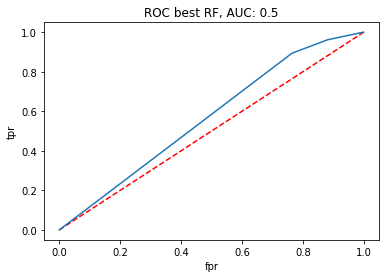

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

### Tabla de métricas

In [76]:
precision, recall, thresholds_2 = precision_recall_curve(y_test, y_scores)
thresholds_2 = np.append(thresholds_2, 1)

In [77]:
(precision.shape, recall.shape, thresholds_2.shape)

((11,), (11,), (11,))

In [78]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({
        'threshold': thresholds_2,
        'precision': precision, 
        'recall': recall})
    
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [79]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.008547,0.195071,1.000000,0.326459,1.000000,1.000000,0.000000,0.000000
1,0.040449,0.195136,0.999988,0.326550,0.999988,0.999575,0.000425,0.000012
2,0.056194,0.195428,0.999876,0.326953,0.999876,0.997605,0.002395,0.000124
3,0.064516,0.206623,0.968187,0.340565,0.968187,0.900943,0.099057,0.031813
4,0.065329,0.206753,0.968015,0.340731,0.968015,0.900065,0.099935,0.031985
5,0.146953,0.209147,0.961887,0.343587,0.961887,0.881460,0.118540,0.038113
6,0.153153,0.220694,0.894469,0.354037,0.894469,0.765451,0.234549,0.105531
7,0.181818,0.220747,0.894111,0.354076,0.894111,0.764912,0.235088,0.105889
8,0.205508,0.220761,0.894111,0.354095,0.894111,0.764846,0.235154,0.105889
9,0.246518,0.220779,0.893308,0.354054,0.893308,0.764082,0.235918,0.106692


Determinando la k100%

In [84]:
df_ingest.columns

Index(['folio', 'fecha_creacion', 'hora_creacion', 'dia_semana',
       'delegacion_inicio', 'incidente_c4', 'tipo_entrada', 'mes', 'label'],
      dtype='object')

In [106]:
k100 = df_ingest.label.value_counts()[0] / len(df_ingest.fecha_creacion.unique())
k100

417.45733788395904

In [107]:
k20 = 20 / k100
k20

0.04790908719290357

In [138]:
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.precision_score(y_true, y_pred)

In [139]:
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])
    
    return metrics.recall_score(y_true, y_pred)

In [140]:
def get_top_k(y_scores, k):
    y_scores_sorted = y_scores.sort_values(ascending=False)
    total = len(y_scores)
    end_index = round(total * k)
    return y_scores[:end_index].copy()

In [158]:
def pr_k_curve(y_true, y_scores, k_target, save_target):
    k_values = list(np.arange(0.01, 1, 0.01))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        d['precision'] = precision_at_k(y_true, y_scores, k)
        d['recall'] = recall_at_k(y_true, y_scores, k)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    
    # línea vertical
    plt.axvline(x=k_target, color='b', ls='--', label=f'k@{round(k_target, 2)}')
    plt.title('Curva precision-recall @k')    
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    

    if save_target is not None:
        plt.savefig(save_target, dpi=300)

    return pr_k

,k,precision,recall
0,0.01,0.220779,0.893308
1,0.02,0.220779,0.893308
2,0.03,0.220779,0.893308
3,0.04,0.220779,0.893308
4,0.05,0.220779,0.893308
...,...,...,...
94,0.95,0.195428,0.999876
95,0.96,0.195428,0.999876
96,0.97,0.195428,0.999876
97,0.98,0.195428,0.999876


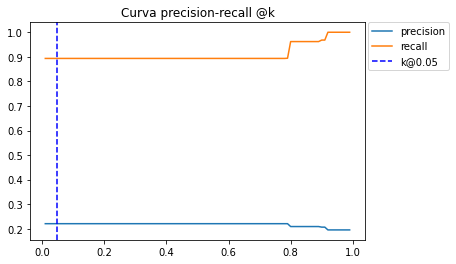

In [159]:
pr_k_curve(y_test, y_scores, k20, 'pr_k_curve')

## Terminación

In [52]:
from IPython.display import Audio
sound_file = './bells.mp3'
Audio(sound_file, autoplay=True)